# Predicting Stock Movement using ARIMA Model

In this notebook will be performing:
    1. Importing Libraries
    2. Importing Dataset
    3. Stock of choice Analysis(ACF, PACF)
    4. Stock Prediction

## Importing Libraries

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from alpha_vantage.timeseries import TimeSeries
from config import *

In [3]:
warnings.filterwarnings('ignore')

## Import Data From Alpha Vantage

In [4]:
#SET ALPHA VINTAGE ENVIRONMENT VARIABLES 
def get_data(symbol,size='compact',period='daily'):
    '''
    function return timeseried data of a given ticker symbol, and for given intervale
    '''
    if period=='daily':
        ts=TimeSeries(key=ALPHA_API_KEY,output_format='pandas')
        df=ts.get_daily(symbol,outputsize=size)[0]
        
    elif period=='weekly':
        ts=TimeSeries(key=ALPHA_API_KEY,output_format='pandas')
        df=ts.get_weekly(symbol,outputsize=size)[0]
    elif period=='monthly':
        ts=TimeSeries(key=ALPHA_API_KEY,output_format='pandas')
        df=ts.get_monthly(symbol,outputsize=size)[0]
    else:
        ts=TimeSeries(key=ALPHA_API_KEY,output_format='pandas')
        df=ts.get_intraday(symbol,interval=period,outputsize=size)[0]
    return df.sort_values('date')

## Prepare data for ARIMA

Create a column for daily returns. Take the log of the returns to normalize large fluctuations.

In [5]:
def plot_returns(df,column,window=20):
    '''
    function return log return of give dataframe
    '''
    df=df[[column]].sort_values('date')
    df['returns']=np.log(df[column]).diff()
    df.dropna(inplace=True)
    rolmean = df['returns'].rolling(window).mean()
    rolstd = df['returns'].rolling(window).std()
    
    plt.figure(figsize=(12, 6))
    orig = plt.plot(df['returns'], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(loc='best')
    plt.show(block=False)
    return df

## Test for Stationarity of the udiff series

In [22]:
# Perform Dickey-Fuller test

def dickey_fuller_test(df,autolag='AIC'):
    '''
    Perform Dickey-Fuller test for Stationarity
    '''
    dftest = sm.tsa.adfuller(df.returns, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({0})'.format(key)] = value
    
    return dfoutput

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help choose hyperparameters for the ARIMA model.

The ACF gives a measure of how much each "y" value is correlated to the previous n "y" values prior. 

The PACF is the partial correlation function gives (a sample of) the amount of correlation between tow "y" values separated by n lags excluding the impact of all the "y" values in between them. 

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
def plot_acf_pacf(df,lag=10):
    '''
    the autocorrelation chart provides just the correlation at increasing lags
    '''
    fig_acf, ax_acf = plt.subplots(figsize=(12,5))
    plot_acf(df['returns'].values, lags=lag, ax=ax_acf)
    fig_pacf, ax_pacf = plt.subplots(figsize=(12,5))
    plot_pacf(df['returns'].values, lags=lag, ax=ax_pacf)
    plt.show()




## Build ARIMA Model

In [8]:
from statsmodels.tsa.arima_model import ARMA

def simple_ARMA(df,hyper=(1,0,1)):
    # Notice that you have to use udiff - the differenced data rather than the original data. 
    ar1 = ARMA(tuple(df.returns.values),hyper).fit()
    plt.figure(figsize=(12, 8))
    plt.plot(df.returns.values, color='blue')
    preds = ar1.fittedvalues
    plt.plot(preds, color='red')
    plt.show() 
    return ar1

In [9]:
def pred_simple_ARMA(df,ar1,steps=2):

    steps = steps

    forecast = ar1.forecast(steps=steps)[0]

    plt.figure(figsize=(12, 8))
    plt.plot(df.returns.values, color='blue')

    preds = ar1.fittedvalues
    plt.plot(preds, color='red')

    plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(df.returns.values)+1, len(df.returns.values)+3)), color='green')
    plt.plot(pd.DataFrame(forecast,index=range(len(df.returns.values)+1, len(df.returns.values)+1+steps)), color='green')
    plt.title('Display the predictions with the ARIMA model')
    plt.show()
    
    return forecast

# With Training and Test Split

In [10]:
#Training and Testing Spliting 
def training_testing_spliting(df,column,frac=0.8):
    
    train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
    plt.figure(figsize=(12,7))
    plt.title('WMT Prices')
    plt.xlabel('Dates')
    plt.ylabel('Prices')
    plt.plot(df[column], 'blue', label='Training Data')
    plt.plot(test_data[column], 'green', label='Testing Data')
    #plt.xticks(np.arange(0,1857, 300), df['date'][0:1857:300])
    plt.legend()
    return train_data, test_data

In [55]:

def Recurring_ARMA(train_ar,test_ar,pdf=(5,1,0)):

    # https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    history = [x for x in train_ar]
    print(type(history))
    predictions = list()
    for t in range(len(test_ar)):
        model = ARIMA(history, order=pdf)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_ar[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = np.sqrt(mean_squared_error(test_ar, predictions))
    print('Testing Mean Squared Error: %.3f' % error)
    return predictions,model_fit
    #error2 = smape_kun(test_ar, predictions)
    #print('Symmetric mean absolute percentage error: %.3f' % error2)

In [12]:
def plot_pred_test(train_data,test_data,predictions):
    plt.figure(figsize=(12,7))
    plt.plot(train_data['4. close'], 'green', color='blue', label='Training Data')
    plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
             label='Predicted Price')
    plt.plot(test_data.index, test_data['4. close'].values, color='red', label='Actual Price')
    plt.title('Prices Prediction')
    plt.xlabel('Dates')
    plt.ylabel('Prices')
    #plt.xticks(np.arange(0,1857, 300), df['Date'][0:1857:300])
    plt.legend()

# Predicted Prices Chart

In [67]:
def plot_forecast_test(test_data,predicition):

    plt.figure(figsize=(12,7))
    plt.plot(test_data.index, predictions, color='green', linestyle='dashed', 
             label='Predicted Price')
    plt.plot(test_data.index, test_data['4. close'], color='red', label='Actual Price')
    #plt.xticks(np.arange(1486,1856, 60), df['Date'][1486:1856:60])
    plt.title('Prices Prediction')
    plt.xlabel('Dates')
    plt.ylabel('Prices')
    plt.legend()

In [14]:
df=get_data("WMT",size='full')

In [111]:
df.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2000-05-22,57.69,57.69,56.19,57.38,4628100.0
2000-05-23,57.56,58.38,56.81,57.19,4291000.0
2000-05-24,55.25,57.00,52.75,56.88,10341500.0
2000-05-25,55.81,56.69,54.06,55.00,4619200.0
2000-05-26,54.25,55.00,53.13,54.00,3996400.0


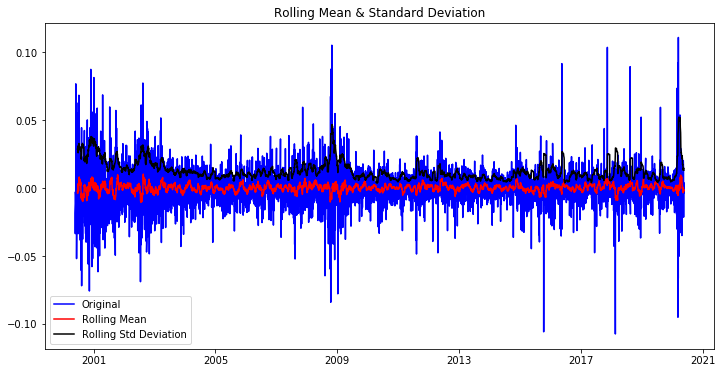

In [112]:
df_day=plot_returns(df,'4. close')

In [115]:
dickey_fuller_test(df_day)

Test Statistic                -1.353312e+01
p-value                        2.598422e-25
#Lags Used                     3.100000e+01
Number of Observations Used    5.000000e+03
Critical Value (1%)           -3.431659e+00
Critical Value (5%)           -2.862118e+00
Critical Value (10%)          -2.567078e+00
dtype: float64

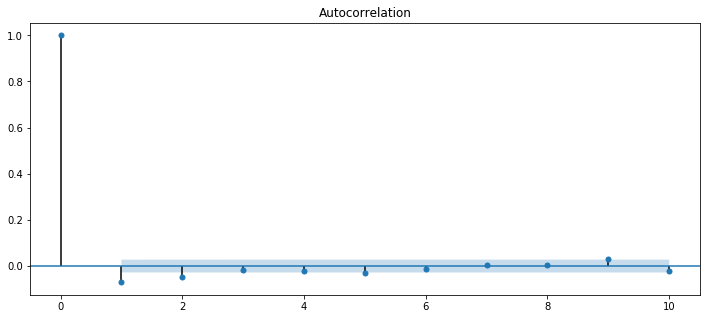

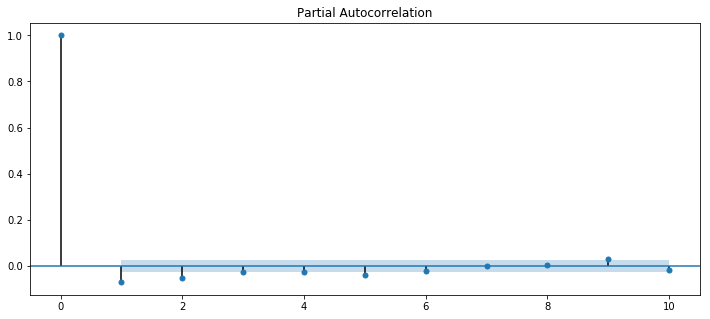

In [116]:
plot_acf_pacf(df_day)

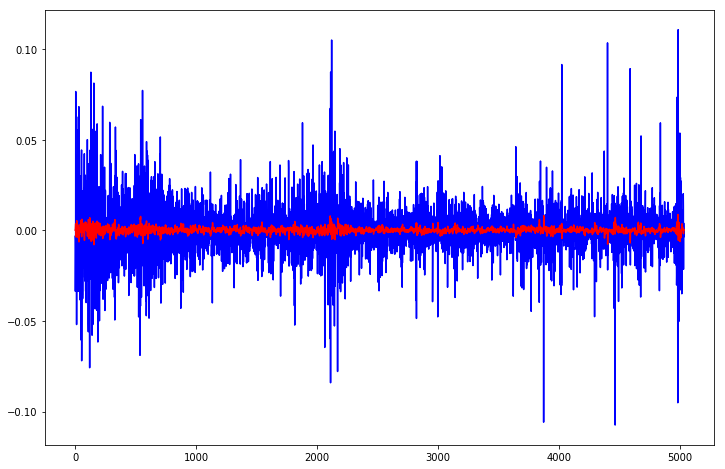

In [117]:
ar1=simple_ARMA(df_day,(2,2))

In [119]:
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 5032
Model:                     ARMA(2, 2)   Log Likelihood               14237.048
Method:                       css-mle   S.D. of innovations              0.014
Date:                Fri, 22 May 2020   AIC                         -28462.096
Time:                        15:14:35   BIC                         -28422.954
Sample:                             0   HQIC                        -28448.382
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.984      0.325      -0.000       0.000
ar.L1.y        0.8548      1.708      0.500      0.617      -2.493       4.203
ar.L2.y       -0.1220      1.067     -0.114      0.909      -2.213       1.969
ma.L1.y       -0.9329      1.709     -0.546      0.585      -4.282       2.416
ma.L2.y        0.1424      1.200      0.119      0.906      -2.210       2.494
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4845           +0.0000j            1.4845            0.0000
AR.2            5.5202           +0.0000j            5.5202            0.0000
MA.1            1.3504           +0.0000j            1.3504            0.0000
MA.2            5.1987           +0.0000j            5.1987            0.0000
-----------------------------------------------------------------------------
"""

## Daily forecasting adjusting for new info

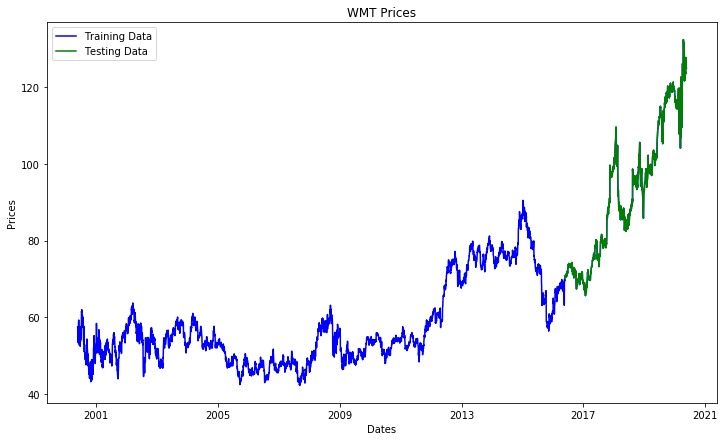

In [129]:
train_data,test_data=training_testing_spliting(df["2009":],'4. close')

In [131]:
test_data.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2016-05-24,69.65,70.420,69.55,70.24,8827986.0
2016-05-25,70.25,70.995,70.24,70.48,7269763.0
2016-05-26,70.69,71.375,70.60,70.85,8692426.0
2016-05-27,70.86,70.890,70.49,70.75,5773666.0
2016-05-31,70.58,71.000,70.48,70.78,8389484.0


In [144]:
train_ar=train_data['4. close'].values
test_ar=test_data['4. close'].values

predictions,Rec_ARMA=Recurring_ARMA(train_ar,test_ar,(5,1,0))

<class 'list'>


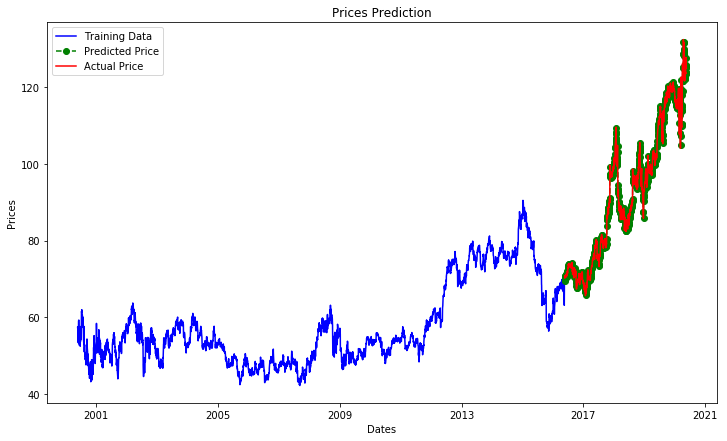

In [158]:
plot_pred_test(train_data,test_data,predictions)

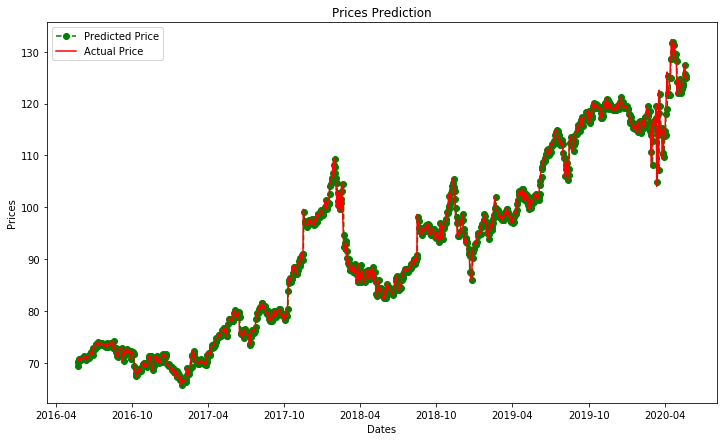

In [160]:
plot_forecast_test(test_data,predictions)

In [161]:
test_data.tail()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2020-05-18,127.50,128.555,126.10,127.66,12874143.0
2020-05-19,131.75,131.990,124.81,124.95,24887982.0
2020-05-20,126.49,126.590,124.63,125.45,10743039.0
2020-05-21,124.89,126.140,124.25,124.99,7289278.0
2020-05-22,125.10,125.350,123.77,124.86,4753095.0


## NEE Analysis 

In [15]:
df=get_data("NEE",size='full')

In [16]:
df.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2000-05-22,47.75,48.25,47.50,47.63,538000.0
2000-05-23,47.75,48.44,47.38,48.13,822900.0
2000-05-24,47.81,49.69,47.81,48.69,2605400.0
2000-05-25,48.25,48.94,47.81,48.88,628200.0
2000-05-26,48.63,50.00,48.50,49.75,851400.0


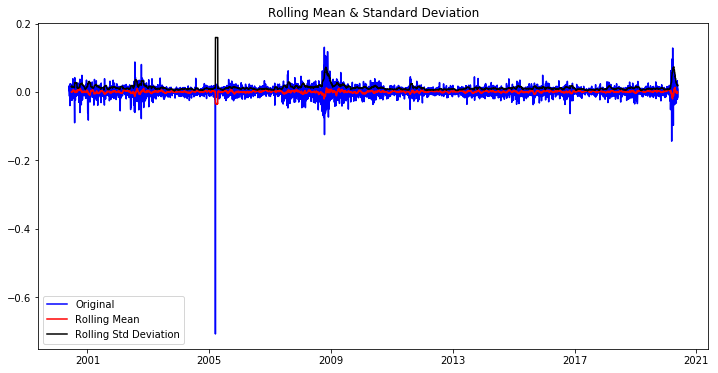

In [17]:
df_day=plot_returns(df,'4. close')

In [23]:
dickey_fuller_test(df_day)

Test Statistic                -1.882232e+01
p-value                        2.022174e-30
#Lags Used                     1.500000e+01
Number of Observations Used    5.016000e+03
Critical Value (1%)           -3.431654e+00
Critical Value (5%)           -2.862116e+00
Critical Value (10%)          -2.567077e+00
dtype: float64

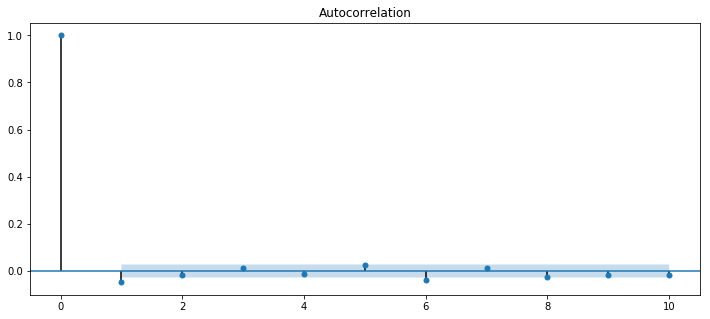

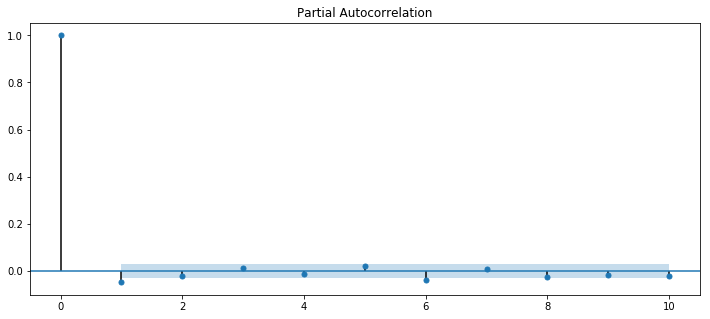

In [24]:
plot_acf_pacf(df_day)

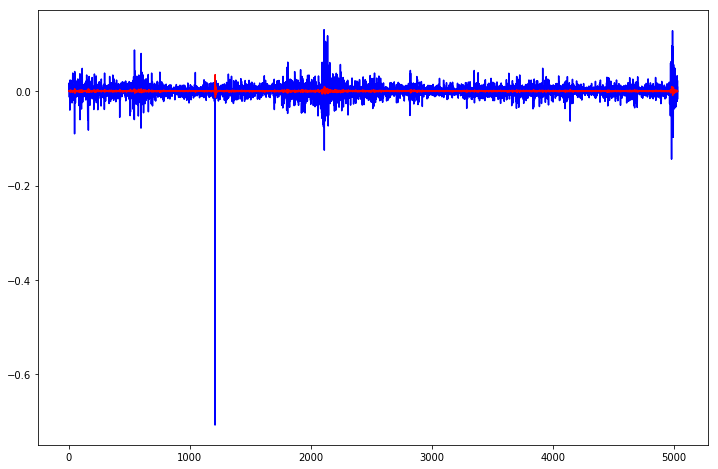

In [48]:
ar1=simple_ARMA(df_day,(2,1))

In [49]:
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 5032
Model:                     ARMA(2, 1)   Log Likelihood               13224.084
Method:                       css-mle   S.D. of innovations              0.017
Date:                Sun, 24 May 2020   AIC                         -26438.168
Time:                        12:54:49   BIC                         -26405.550
Sample:                             0   HQIC                        -26426.740
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.363      0.173      -0.000       0.001
ar.L1.y       -0.8406      0.076    -11.053      0.000      -0.990      -0.692
ar.L2.y       -0.0638      0.014     -4.531      0.000      -0.091      -0.036
ma.L1.y        0.7922      0.075     10.554      0.000       0.645       0.939
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3223           +0.0000j            1.3223            0.5000
AR.2          -11.8513           +0.0000j           11.8513            0.5000
MA.1           -1.2622           +0.0000j            1.2622            0.5000
-----------------------------------------------------------------------------
"""

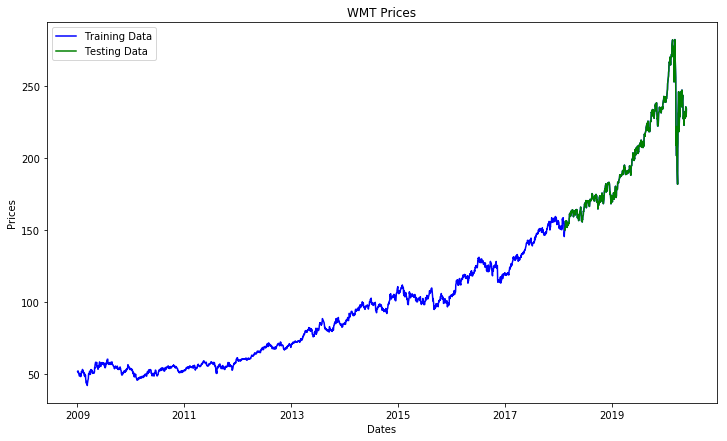

In [50]:
train_data,test_data=training_testing_spliting(df["2009":],'4. close')

In [56]:
train_ar=train_data['4. close'].values
test_ar=test_data['4. close'].values

predictions,Rec_ARMA=Recurring_ARMA(train_ar,test_ar,(5,1,1))

<class 'list'>
Testing Mean Squared Error: 3.846


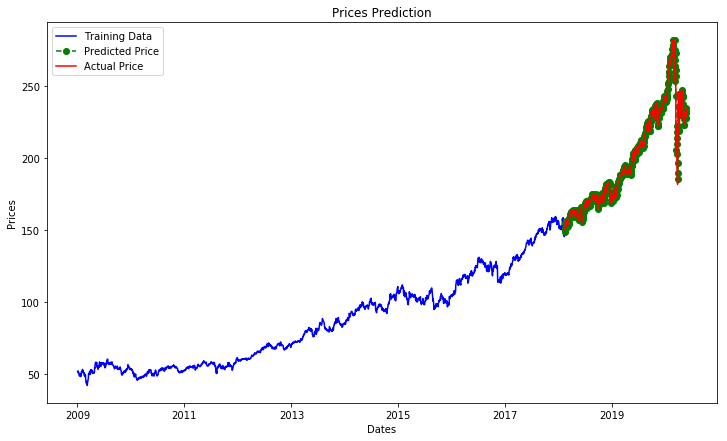

In [57]:
plot_pred_test(train_data,test_data,predictions)

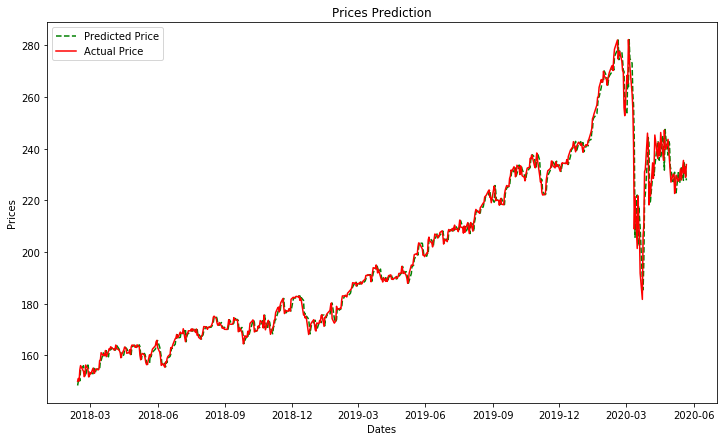

In [68]:
plot_forecast_test(test_data,predictions)

In [69]:
predictions[0]

array([148.33765512])

In [70]:
test_ar[0]

150.0

In [72]:
np.sqrt(mean_squared_error(predictions,test_ar))

3.8464021044727086

In [90]:
pred=pd.Series(np.array(predictions).flatten(),index=test_data.index)

In [97]:
pred.describe()

count    574.000000
mean     198.148911
std       32.824281
min      148.337655
25%      170.560123
50%      189.974259
75%      227.730370
max      282.187034
dtype: float64

In [98]:
test_data['4. close'].describe()

count    574.000000
mean     198.269739
std       32.783472
min      150.000000
25%      170.485000
50%      190.050000
75%      227.772500
max      282.220000
Name: 4. close, dtype: float64